In [1]:
import tensorflow as tf
import json
import h5py
import numpy as np

from utils.augment import random_augment
from utils.mean_subtract import MeanSubtract
from utils.simple_resize import SimpleResize
from utils.extract_patch import ExtractPatch
from utils.scaling import Scaling

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline
tf.reset_default_graph()

/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Create data generator class

In [2]:
class Generator:
    def __init__(self, path, BS, preprocessors=None, classes=2, aug=None):
        """
        path: path to write HDF5 file
        BS: batch size
        preprocessors: preprocessing classes to use to preprocess the images before feeding into the model
        classes: total of distinct classes in dataset
        aug: ratio of data to be augmented, ie: aug=0.2 randomly augments 20% of the images randomly selected from the dataset. 
        yes my implementation is very slow, I just did it for fun, please let me know how I can improve this!
        """
        
        self.BS = BS
        self.preprocessors = preprocessors
        self.classes = classes
        
        self.db = h5py.File(path)
        self.n_img = self.db["labels"].shape[0]
        self.aug = aug
        
    def generate(self):
        ohe = OneHotEncoder(n_values=self.classes, sparse=False)
        a_img = []
        a_lbl = []
        for i in np.arange(0, self.n_img, self.BS):
            images = self.db["images"][i:i+self.BS]
            labels = self.db["labels"][i:i+self.BS]
            labels = ohe.fit_transform(labels.reshape(-1, 1))
            
            if self.preprocessors is not None:
                proc_img = []
                for image in images:
                    for p in self.preprocessors:
                        image = p.preprocess(image)
                        
                    proc_img.append(image)
                    
                images = np.array(proc_img)
                
            if self.aug != None:
                value = int(self.aug * len(images))
                idxs = sorted(np.random.choice(len(images), value))
                a, b = images[idxs], labels[idxs]
                for img, l in zip(a, b):
                    augmented = random_augment(img)
                    a_img.append(augmented)
                    a_lbl.append(l)
                
            yield images, labels
        
        if self.aug != None:
            a_img = np.array(a_img)
            a_lbl = np.array(a_lbl)
            for i in np.arange(0, len(a_img), self.BS):
                images = a_img[i:i+self.BS]
                labels = a_lbl[i:i+self.BS]
                
                yield images, labels
            
    def close(self):
        self.db.close()

### AlexNet

In [3]:
def conv2d(x, filters, ksize, strides=1, padding="same", kreg=0.0002, activation=tf.nn.relu):
    conv = tf.layers.conv2d(x, filters=filters, kernel_size=ksize, strides=strides,
                           padding=padding, activation=activation,
                           kernel_initializer=tf.glorot_uniform_initializer(),  # the default kernel initializer in Keras
                           kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=kreg))
    conv = tf.layers.batch_normalization(conv, axis=-1)
    
    return conv

def max_pool(x, is_train, pool_size=3, strides=2):
    pool = tf.layers.max_pooling2d(x, pool_size=pool_size, strides=strides)
    pool = tf.layers.dropout(pool, rate=0.25, training=is_train)
    
    return pool

In [4]:
class AlexNet:
    def __init__(self, width, height, channels, classes):
        self.X = tf.placeholder(tf.float32, shape=(None, height, width, channels), name="X")
        self.y = tf.placeholder(tf.float32, shape=(None, classes), name="y")
        self.is_train = tf.placeholder(tf.bool)
        
        x = self.model(self.X, self.is_train)
        self.logits = tf.layers.dense(x, units=classes, activation=None)
        
        # using a static 1e-3 learning rate, the model learned nothing (loss didn't go down)
        # the learning rate decay proves to improve results as compared to no decay
        global_step = tf.train.create_global_step()
        lr = tf.train.cosine_decay(1e-5, global_step, decay_steps=1000)
        
        opt = tf.train.AdamOptimizer(learning_rate=lr)
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.logits))
        self.train_op = opt.minimize(self.loss)
        
        sm = tf.nn.softmax(self.logits)
        self.predict = tf.argmax(sm, axis=-1)
        ys = tf.argmax(self.y, axis=-1)
        correct = tf.equal(self.predict, ys)
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def model(self, X, is_train):
        x = conv2d(X, 96, 11, 4)
        x = max_pool(x, is_train, 3, 3)
        
        x = conv2d(x, 256, 5)
        x = max_pool(x, is_train, 3, 3)
        
        x = conv2d(x, 384, 3)
        x = conv2d(x, 384, 3)
        x = conv2d(x, 256, 3)
        x = max_pool(x, is_train, 3, 3)
        
        x = tf.layers.flatten(x)
        
        x = tf.layers.dense(x, units=4096, activation=tf.nn.relu,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0002))
        x = tf.layers.batch_normalization(x)
        x = tf.layers.dropout(x, rate=0.5, training=is_train)
        
        x = tf.layers.dense(x, units=4096, activation=tf.nn.relu,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0002))
        x = tf.layers.batch_normalization(x)
        x = tf.layers.dropout(x, rate=0.5, training=is_train)
        
        return x

### Initialization

In [5]:
epochs = 200
BS = 128
width = 227
height = 227
channels = 3
classes = 2

train_path = "hdf5/train.hdf5"
val_path = "hdf5/val.hdf5"
mean_path = "rgb_means.json"

In [6]:
# preprocessors
means = json.loads(open(mean_path).read())   
ms = MeanSubtract(means["R"], means["G"], means["B"])  # subtracting the means from images as described in AlexNet paper
patch = ExtractPatch(height, width)  # randomly extract (227, 227) patch from the (256, 256) images
sr = SimpleResize(height, width)  # resizing the images without caring about the aspect ratio
#sc = Scaling(255)

train_generator = Generator(train_path, BS, [patch, ms], aug=0.2)
val_generator = Generator(val_path, BS, [sr, ms])

In [7]:
net = AlexNet(width, height, channels, classes)

X = net.X
y = net.y
is_train = net.is_train

train_op = net.train_op
loss = net.loss
acc = net.accuracy

tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", acc)
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
m_sum = tf.summary.merge_all()

saver = tf.train.Saver()
init = tf.global_variables_initializer()

INFO:tensorflow:Summary name conv2d/kernel:0 is illegal; using conv2d/kernel_0 instead.
INFO:tensorflow:Summary name conv2d/bias:0 is illegal; using conv2d/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization/gamma:0 is illegal; using batch_normalization/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization/beta:0 is illegal; using batch_normalization/beta_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/gamma:0 is illegal; using batch_normalization_1/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:

In [8]:
%%time
with tf.Session() as sess:
    writer = tf.summary.FileWriter("log", sess.graph)
    init.run()
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    master_counter = 0
    for epoch in range(epochs):
        tloss = 0.0
        tacc = 0.0
        count = 0
        for xb, yb in train_generator.generate():
            _, bloss, bacc, summary = sess.run([train_op, loss, acc, m_sum], feed_dict={X: xb, y: yb, is_train: True})
            writer.add_summary(summary, master_counter)
            tloss += bloss
            tacc += bacc
            count += 1
            master_counter += 1
            
        train_loss.append(bloss)
        train_acc.append(bacc)
            
        vloss = 0.0
        vacc = 0.0
        count2 = 0
        for xb, yb in val_generator.generate():
            bloss, bacc = sess.run([loss, acc], feed_dict={X: xb, y: yb, is_train: False})
            vloss += bloss
            vacc += bacc
            count2 += 1
            
        val_loss.append(bloss)
        val_acc.append(bacc)
            
        if (epoch+1)%50 == 0:
            saver.save(sess, "save/{}.ckpt".format(epoch+1))
            
        stuff = [epoch, tloss/count, tacc/count, vloss/count2, vacc/count2]   
        print("{}\tloss: {:.6f} acc: {:.3f}  val_loss: {:.6f} val_acc: {:.3f}".format(*stuff))

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


0	loss: 1.168518 acc: 0.515  val_loss: 0.671175 val_acc: 0.587
1	loss: 0.727919 acc: 0.550  val_loss: 0.658029 val_acc: 0.640
2	loss: 0.685702 acc: 0.589  val_loss: 0.641738 val_acc: 0.657
3	loss: 0.659661 acc: 0.618  val_loss: 0.629465 val_acc: 0.673
4	loss: 0.642280 acc: 0.640  val_loss: 0.616581 val_acc: 0.694
5	loss: 0.622377 acc: 0.664  val_loss: 0.606601 val_acc: 0.684
6	loss: 0.598049 acc: 0.688  val_loss: 0.581395 val_acc: 0.700
7	loss: 0.584005 acc: 0.701  val_loss: 0.572133 val_acc: 0.710
8	loss: 0.564746 acc: 0.719  val_loss: 0.576474 val_acc: 0.697
9	loss: 0.551051 acc: 0.729  val_loss: 0.623021 val_acc: 0.658
10	loss: 0.539525 acc: 0.735  val_loss: 0.528436 val_acc: 0.738
11	loss: 0.534386 acc: 0.739  val_loss: 0.535967 val_acc: 0.737
12	loss: 0.516473 acc: 0.752  val_loss: 0.543965 val_acc: 0.724
13	loss: 0.511821 acc: 0.756  val_loss: 0.554265 val_acc: 0.708
14	loss: 0.504278 acc: 0.763  val_loss: 0.527806 val_acc: 0.736
15	loss: 0.494951 acc: 0.768  val_loss: 0.519401 v

128	loss: 0.232648 acc: 0.901  val_loss: 0.313159 val_acc: 0.870
129	loss: 0.227876 acc: 0.904  val_loss: 0.308917 val_acc: 0.870
130	loss: 0.236127 acc: 0.899  val_loss: 0.285501 val_acc: 0.882
131	loss: 0.235398 acc: 0.903  val_loss: 0.304617 val_acc: 0.869
132	loss: 0.231443 acc: 0.903  val_loss: 0.282608 val_acc: 0.879
133	loss: 0.232870 acc: 0.900  val_loss: 0.291489 val_acc: 0.881
134	loss: 0.228617 acc: 0.903  val_loss: 0.320192 val_acc: 0.865
135	loss: 0.224472 acc: 0.904  val_loss: 0.319494 val_acc: 0.869
136	loss: 0.226694 acc: 0.906  val_loss: 0.303098 val_acc: 0.876
137	loss: 0.228303 acc: 0.902  val_loss: 0.409425 val_acc: 0.826
138	loss: 0.223691 acc: 0.908  val_loss: 0.317846 val_acc: 0.871
139	loss: 0.218670 acc: 0.911  val_loss: 0.299725 val_acc: 0.876
140	loss: 0.220381 acc: 0.906  val_loss: 0.307012 val_acc: 0.876
141	loss: 0.211603 acc: 0.908  val_loss: 0.334118 val_acc: 0.863
142	loss: 0.220936 acc: 0.908  val_loss: 0.291636 val_acc: 0.886
143	loss: 0.210611 acc: 0

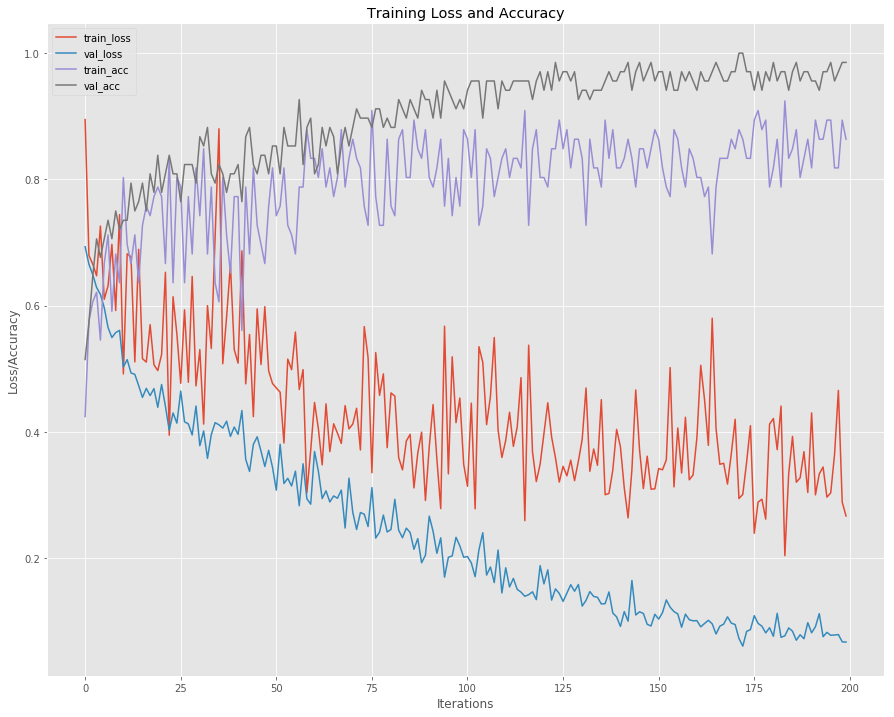

In [9]:
plt.style.use("ggplot")
plt.figure(figsize=(15,12))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

### Testing

In [10]:
tf.reset_default_graph()

test_generator = Generator(val_path, BS, [sr, ms])
net = AlexNet(width, height, channels, classes)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "save/200.ckpt")
    
    preds = []
    acc = 0.0
    count = 0
    for xb, yb in test_generator.generate():
        pred, tacc = sess.run([net.predict, net.accuracy], feed_dict={net.X: xb, net.y: yb, net.is_train: False})
        acc += tacc
        preds.append(pred)
        count += 1
        
    print("Testing accuracy: {:.3f}".format(acc/count))

INFO:tensorflow:Restoring parameters from save/200.ckpt
Testing accuracy: 0.883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

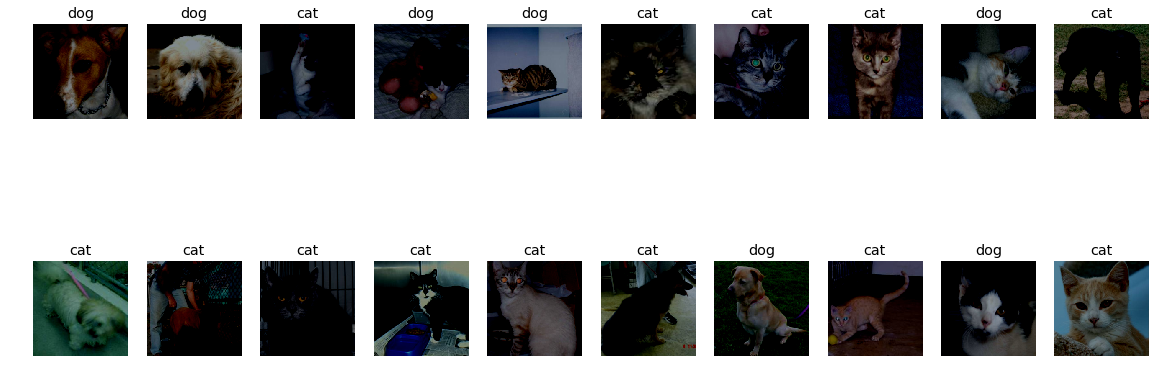

In [12]:
import cv2
Generator(val_path, BS, [sr])
xb, yb = next(test_generator.generate())
names = {0: "cat", 1: "dog"}

plt.figure(figsize=(20, 8))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(cv2.cvtColor(xb[i]/255.0, cv2.COLOR_BGR2RGB))
    plt.title(names[preds[i][0]])
    plt.axis("off")

plt.show()